In [15]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import csv
%matplotlib notebook

from scipy import signal
from scipy.signal import butter, lfilter

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.model_selection import cross_val_score
import pickle

from pynput.keyboard import Key, Controller


def read_arduino(ser,inputBufferSize):
#    data = ser.readline(inputBufferSize)
    data = ser.read(inputBufferSize)
    out =[(int(data[i])) for i in range(0,len(data))]
    return out

def process_data(data):
    data_in = np.array(data)
    result = []
    i = 1
    while i < len(data_in)-1:
        if data_in[i] > 127:
            # Found beginning of frame
            # Extract one sample from 2 bytes
            intout = (np.bitwise_and(data_in[i],127))*128
            i = i + 1
            intout = intout + data_in[i]
            result = np.append(result,intout)
        i=i+1
    return result

# moving average found on quora
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def butter_highpass(cutoff, fs, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=6):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

pkl_filename = "pickle_model_knn2_BIG_onlyleftright.pkl"

with open(pkl_filename, 'rb') as file:
    clf = pickle.load(file)
    
keyboard = Controller()

In [16]:
# use this to find ports
from serial.tools import list_ports

ports = list_ports.comports()
for port in ports:
    print(port)

/dev/cu.HC-05-DevB - n/a
/dev/cu.JustinsAirPods-Wireless - n/a
/dev/cu.BLAST-Port - n/a
/dev/cu.JustinsiPhone-Wirelessi - n/a
/dev/cu.Bluetooth-Incoming-Port - n/a
/dev/cu.usbmodem14101 - Arduino Leonardo


In [19]:
baudrate = 230400
cport = '/dev/cu.usbmodem14101'  # set the correct port before you run it
#cport = "/dev/cu.usbserial-DJ00E2W2"
#cport = '/dev/tty.usbmodem141101'  # set the correct port before run it
ser = serial.Serial(port=cport, baudrate=baudrate)

In [20]:
threshold = 45

# take continuous data stream 
inputBufferSize = 10000 # keep betweein 2000-20000
ser.timeout = inputBufferSize/20000.0  # set read timeout, 20000 is one second
#this is the problem line on the mac
# ser.set_buffer_size(rx_size = inputBufferSize)

#%matplotlib notebook

#print(actions)

total_time = 5*60; # time in seconds [[1 s = 20000 buffer size]]
max_time = 10.0; # time plotted in window [s]
N_loops = 20000.0/inputBufferSize*total_time

T_acquire = inputBufferSize/20000.0    # length of time that data is acquired for 
N_max_loops = max_time/T_acquire    # total number of loops to cover desire time window

#fig = plt.figure()
#ax1 = fig.add_subplot(1,1,1)
#plt.ion()
#fig.show()
#fig.canvas.draw()

frequency = 10000

window_active = False #tag as to whether 

data_old = []
print("go")
for k in range(0,int(N_loops)):
    data = read_arduino(ser,inputBufferSize)
    data_temp = process_data(data)
    if k==0:
        data_plot = data_temp
    else:
        data_plot = np.append(data_plot,data_temp) 
    t = (min(k+1,N_loops))*inputBufferSize/20000.0*np.linspace(0,1,(data_plot).size)
    
    filtered_data_temp = moving_average(data_temp,1000)
    
    if window_active == False:
        range_data_temp = abs(max(filtered_data_temp) - min(filtered_data_temp))
        if range_data_temp > threshold :
            print("event")
            window_active = True
            window_data = np.append(data_old,data_temp)
            window_index = 1
    else:
        window_data = np.append(window_data,data_temp)
        window_index = window_index + 1
        if window_index == 3:
            # filtering
            filtered = moving_average(window_data,1000)            #MOVING AVERAGE DATA       
            filtlength = len(filtered)
            indices2 = np.arange(1,filtlength+1,1)#UPDATE INDICES FOR MOVING AVERAGE
            time = indices2 / frequency
            fs = 10000
            fc = 15  # Cut-off frequency of the filter
            w = fc / (fs / 2) # Normalize the frequency
            b, a = signal.butter(5, w, 'low') # butter filter
            output = signal.filtfilt(b, a, filtered)
            #features
            std_dev = np.sqrt(np.var(output)) #Standard Deviation
            
            maximum = max(output)
            max_index = np.where(output == maximum)
            
            minimum = min(output)
            min_index = np.where(output == minimum)
            
            diff = max_index[0]-min_index[0]
            
            prediction = clf.predict([[std_dev,diff]])
            print(prediction)
            
            if prediction == ['right']:
                keyboard.press(Key.right)
                keyboard.release(Key.right)
            else:
                keyboard.press(Key.left)
                keyboard.release(Key.left)
            
            #End window process
            window_active = False
            
        
    data_old = data_temp
#    plt.xlim([0,max_time])
#    ax1.clear()
#    ax1.set_xlim(0, max_time)
#    plt.xlabel('time [s]')
#    ax1.plot(t,data_plot)
#    fig.canvas.draw()    
#    plt.show()

go
event
['right']
event
['left']
event
['right']
event
['left']
event
['right']
event
['right']
event
['left']
event
['left']
event
['left']
event
['left']
event
['left']
event
['right']
event


SerialException: read failed: [Errno 6] Device not configured

In [11]:
print(std_dev)
print(diff)

20.036057773830773
[4841]


In [21]:
# close serial port if necessary
if ser.read():
    ser.flushInput()
    ser.flushOutput()
    ser.close()

SerialException: read failed: [Errno 6] Device not configured

[556.38  556.403 556.424 ... 560.181 560.166 560.15 ]


<IPython.core.display.Javascript object>


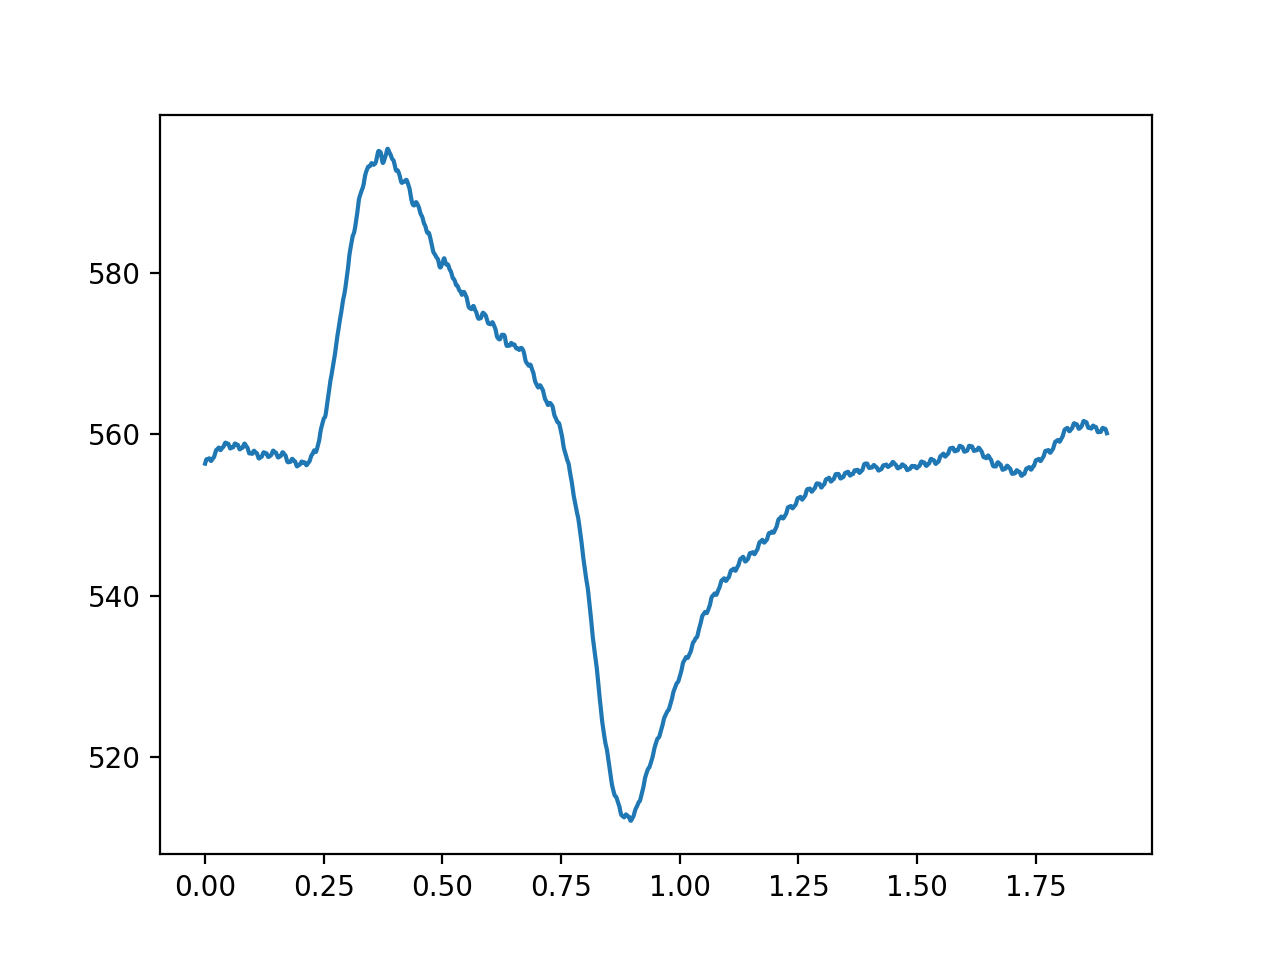

In [65]:
#filtered = moving_average(data_plot,1000)            #MOVING AVERAGE DATA
print(filtered)
filtlength = len(filtered)

indices2 = np.arange(1,filtlength+1,1)#UPDATE INDICES FOR MOVING AVERAGE
time = indices2 / 10000
fig = plt.figure         #PLOT MOVING AVERAGE
plt.plot(time,filtered)
plt.show()